**Use GPU: Runtime -> Change runtime type -> GPU (Hardware Accelerator)**

Setup

In [1]:
!cat ~/.keras/keras.json

{
    "epsilon": 1e-07, 
    "floatx": "float32", 
    "image_data_format": "channels_last", 
    "backend": "tensorflow"
}

Mini-VGGNet

In [1]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

In [2]:
class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

Train MiniVGGNet (CIFAR10)

In [3]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def train_minivggnet_cifar10():
    # load the training and testing data, then scale it into the
    # range [0, 1]
    print("[INFO] loading CIFAR-10 data...")
    ((trainX, trainY), (testX, testY)) = cifar10.load_data()
    trainX = trainX.astype("float") / 255.0
    testX = testX.astype("float") / 255.0

    # convert the labels from integers to vectors
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY)
    testY = lb.transform(testY)

    # initialize the label names for the CIFAR-10 dataset
    labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9, nesterov=True)
    model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # train the network
    print("[INFO] training network...")
    H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=40, verbose=1)

    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=64)
    print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

    return H

In [9]:
H = train_minivggnet_cifar10()

[INFO] loading CIFAR-10 data...
[INFO] compiling model...
[INFO] training network...
Epoch 1/40
782/782 [==============================] - 8s 9ms/step - loss: 1.9554 - accuracy: 0.3858 - val_loss: 1.2627 - val_accuracy: 0.5585
Epoch 2/40
782/782 [==============================] - 7s 9ms/step - loss: 1.1738 - accuracy: 0.5938 - val_loss: 1.0239 - val_accuracy: 0.6420
Epoch 3/40
782/782 [==============================] - 7s 9ms/step - loss: 0.9636 - accuracy: 0.6618 - val_loss: 0.8900 - val_accuracy: 0.6889
Epoch 4/40
782/782 [==============================] - 7s 9ms/step - loss: 0.8413 - accuracy: 0.7040 - val_loss: 0.9556 - val_accuracy: 0.6599
Epoch 5/40
782/782 [==============================] - 7s 9ms/step - loss: 0.7744 - accuracy: 0.7266 - val_loss: 0.7077 - val_accuracy: 0.7501
Epoch 6/40
782/782 [==============================] - 7s 9ms/step - loss: 0.7112 - accuracy: 0.7503 - val_loss: 0.6568 - val_accuracy: 0.7712
Epoch 7/40
782/782 [==============================] - 7s 9ms/st

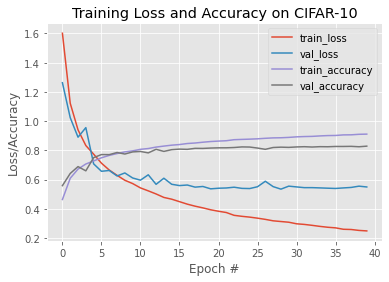

In [18]:
%matplotlib inline

# plot the training loss and accuracy
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()